# XGBoost and LightGBM: using categorical variables (not one-hot encoding)

Take small dataset, set stroke team feature as categorical (rather than one-hot encoded).

Fit XGBoost and LightGBM multiclass classification model. 

Aim:
* Explore how to calculate SHAP values.
* What's the difference between providing background dataset vs not for TreeEnsemble?



## Import libraries

In [26]:
# pip install lightgbm if necessary
!pip install lightgbm

In [27]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

import xgboost as xgb

from xgboost import XGBClassifier
from xgboost import DMatrix
from lightgbm import LGBMClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

from matplotlib.lines import Line2D

# add histograms to dependency plots
import matplotlib.gridspec as gridspec

import pickle
import shap

from os.path import exists

import math

import importlib
# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

import time

Report the time duration to run notebook

In [28]:
start_time = time.time()

## Set up paths and filenames

In [29]:
@dataclass(frozen=True)
class Paths:
    data_read_path: str = '../data/'
    data_read_filename: str = '02_reformatted_data_ml_230709.csv'
    notebook: str = '230719_'
    model_text: str = 'lgbm_all_data_6_features'

paths = Paths()

## Import data

Full dataset.

In [30]:
filename = paths.data_read_path + paths.data_read_filename
data = pd.read_csv(filename)

In [31]:
class_names = data['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

Get y data

In [87]:
y_train_data = data['discharge_disability'].head(5000)
y_test_data = data['discharge_disability'].tail(1000)

# For the X data, create two datasets (categorical and one hot encoded features).

## Format data for categorical representation

Define selected features

In [32]:
X_selected_features = ['prior_disability','stroke_severity','stroke_team_id']

Define data type

In [33]:
feature_types = {
    'prior_disability': 'int',
    'stroke_severity': 'int',
    'stroke_team_id': 'category',
    'discharge_disability': 'category'
}

In [34]:
X_data_cat = data[X_selected_features]

In [35]:
# Set types
for col in list(X_data_cat):
    X_data_cat[col] = X_data_cat[col].astype(feature_types[col])   

Take a reduced dataset to play with

In [36]:
X_train_data_cat = X_data_cat.head(5000)
X_test_data_cat = X_data_cat.tail(1000)

Get X and Y

X_train_data_cat = train_data_cat.drop('discharge_disability', axis=1)
y_train_data_cat = train_data_cat['discharge_disability']

X_test_data_cat = test_data_cat.drop('discharge_disability', axis=1)
y_test_data_cat = test_data_cat['discharge_disability']

Get feature names

In [38]:
features_cat = list(X_train_data_cat)

## Format data for one hot encoded feature representation

Convert some categorical features to one hot encoded features.

Define a function

Define selected features

In [39]:
selected_features = ['prior_disability','stroke_severity','stroke_team']

In [40]:
X_data_ohe = data[selected_features]

In [41]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

In [42]:
features_to_one_hot = ["stroke_team"]
list_prefix = ["team"]

for feature, prefix in zip(features_to_one_hot, list_prefix):
    X_data_ohe = convert_feature_to_one_hot(X_data_ohe, feature, prefix)

Take a reduced dataset to play with

In [43]:
X_train_data_ohe = X_data_ohe.head(5000)
X_test_data_ohe = X_data_ohe.tail(1000)

Get X and y

X_train_data_ohe = train_data_ohe.drop('discharge_disability', axis=1)
y_train_data_ohe = train_data_ohe['discharge_disability']

X_test_data_ohe = test_data_ohe.drop('discharge_disability', axis=1)
y_test_data_ohe = test_data_ohe['discharge_disability']

Get list of features in dataset, post one hot encoding.

In [45]:
features_ohe = list(X_train_data_ohe)

# Fit four models

LightGBM with stroke team as categorical
LightGBM with stroke team as one hot encoded
XGBoost with stroke team as categorical
XGBoost with stroke team as one hot encoded

## Fit LGBM model

Using categorical stroke team

In [46]:
# Define model
lgbm_model_cat = LGBMClassifier(random_state=42, learning_rate=0.3)

# Fit model
lgbm_model_cat.fit(X_train_data_cat, y_train_data)

# Get predicted probabilities
y_probs = lgbm_model_cat.predict_proba(X_test_data_cat)
y_pred = lgbm_model_cat.predict(X_test_data_cat)

# Calculate error
#(Need convert category type to int otherwise "TypeError: Object with dtype category cannot perform the numpy op subtract")
y_error = y_test_data.astype(np.int8) - y_pred

# Calculate accuracy
accuracy = np.mean(y_error==0)
print (f'Accuracy: {accuracy:0.2f}')

Accuracy: 0.22


## Fit LGBM model

Using one hot encoded stroke team

In [47]:
# Define model
lgbm_model_ohe = LGBMClassifier(random_state=42, learning_rate=0.3)

# Fit model
lgbm_model_ohe.fit(X_train_data_cat, y_train_data)

# Get predicted probabilities
y_probs = lgbm_model_ohe.predict_proba(X_test_data_cat)
y_pred = lgbm_model_ohe.predict(X_test_data_cat)

# Calculate error
y_error = y_test_data.astype(np.int8) - y_pred

# Calculate accuracy
accuracy = np.mean(y_error==0)
print (f'Accuracy: {accuracy:0.2f}')

Accuracy: 0.22


## Fit XGBoost model

Using categorical stroke team

In [48]:
# Define model
xgb_model_cat = XGBClassifier(seed=42, learning_rate=0.5,
                          tree_method="gpu_hist", enable_categorical=True)

# Fit model
xgb_model_cat.fit(X_train_data_cat, y_train_data)

# Get predicted probabilities
y_probs = xgb_model_cat.predict_proba(X_test_data_cat)
y_pred = xgb_model_cat.predict(X_test_data_cat)

# Calculate error
y_error = y_test_data.astype(np.int8) - y_pred

# Calculate accuracy
accuracy = np.mean(y_error==0)
print (f'Accuracy: {accuracy:0.2f}')

Accuracy: 0.22


## Fit XGBoost model

Using one hot encoding stroke team

In [49]:
# Define model
xgb_model_ohe = XGBClassifier(seed=42, learning_rate=0.5,
                          tree_method="gpu_hist")

# Fit model
xgb_model_ohe.fit(X_train_data_ohe, y_train_data)

# Get predicted probabilities
y_probs = xgb_model_ohe.predict_proba(X_test_data_ohe)
y_pred = xgb_model_ohe.predict(X_test_data_ohe)

# Calculate error
y_error = y_test_data - y_pred

# Calculate accuracy
accuracy = np.mean(y_error==0)
print (f'Accuracy: {accuracy:0.2f}')

Accuracy: 0.24


## SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

## Get SHAP values
TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

# Calculate SHAP for LightGBM model. Categorcial feature. With background data.

In [50]:
# Set up explainer using the model and feature values from training set
explainer_lgb_cat_bg = shap.TreeExplainer(lgbm_model_cat, X_train_data_cat)

# Get (and store) Shapley values along with base and feature values
shap_values_extended_lgb_cat_bg = explainer_lgb_cat_bg(X_test_data_cat)

# Shap values exist for each classification in a Tree
# We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
shap_values_lgb_cat_bg = shap_values_extended_lgb_cat_bg.values

AttributeError: 'TreeEnsemble' object has no attribute 'values'

# Calculate SHAP for LightGBM model. Categorical feature. Without background data.

In [51]:
# Set up explainer using the model and feature values from training set
explainer_lgb_cat = shap.TreeExplainer(lgbm_model_cat)

# Get (and store) Shapley values along with base and feature values
shap_values_extended_lgb_cat = explainer_lgb_cat(X_test_data_cat)

# Shap values exist for each classification in a Tree
# We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
shap_values_lgb_cat = shap_values_extended_lgb_cat.values

# Calculate SHAP for LightGBM model. One hot encoded feature. With background data.

In [52]:
# Set up explainer using the model and feature values from training set
explainer_lgb_ohe_bg = shap.TreeExplainer(lgbm_model_ohe, X_train_data_ohe)

# Get (and store) Shapley values along with base and feature values
shap_values_extended_lgb_ohe_bg = explainer_lgb_ohe_bg(X_test_data_ohe)

# Shap values exist for each classification in a Tree
# We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
shap_values_lgb_ohe_bg = shap_values_extended_lgb_ohe_bg.values

AttributeError: 'TreeEnsemble' object has no attribute 'values'

# Calculate SHAP for LightGBM model. One hot encoded feature. Without background data.

In [53]:
# Set up explainer using the model and feature values from training set
explainer_lgb_ohe = shap.TreeExplainer(lgbm_model_ohe)

# Get (and store) Shapley values along with base and feature values
shap_values_extended_lgb_ohe = explainer_lgb_ohe(X_test_data_ohe)

# Shap values exist for each classification in a Tree
# We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
shap_values_lgb_ohe = shap_values_extended_lgb_ohe.values

[LightGBM] [Fatal] The number of features in data (120) is not the same as it was in training data (3).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (120) is not the same as it was in training data (3).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

# Calculate SHAP for XGBoost model. Categorical feature. With background data.

In [54]:
# Set up explainer using the model and feature values from training set
explainer_xgb_cat_bg = shap.TreeExplainer(xgb_model_cat, X_train_data_cat)

# Get (and store) Shapley values along with base and feature values
shap_values_extended_xgb_cat_bg = explainer_xgb_cat_bg(X_test_data_cat)

# Shap values exist for each classification in a Tree
# We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
shap_values_xgb_cat_bg = shap_values_extended_xgb_cat_bg.values

XGBoostError: [10:18:35] ../src/tree/tree_model.cc:869: Check failed: !HasCategoricalSplit(): Please use JSON/UBJSON for saving models with categorical splits.
Stack trace:
  [bt] (0) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x398643) [0x7fecdb598643]
  [bt] (1) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x399a02) [0x7fecdb599a02]
  [bt] (2) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2ca641) [0x7fecdb4ca641]
  [bt] (3) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2e67a7) [0x7fecdb4e67a7]
  [bt] (4) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterSaveModelToBuffer+0x2ad) [0x7fecdb33d76d]
  [bt] (5) /home/kerry/miniconda3/envs/sam10/lib/python3.10/lib-dynload/../../libffi.so.8(+0xa052) [0x7fed3ef6d052]
  [bt] (6) /home/kerry/miniconda3/envs/sam10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x8925) [0x7fed3ef6b925]
  [bt] (7) /home/kerry/miniconda3/envs/sam10/lib/python3.10/lib-dynload/../../libffi.so.8(ffi_call+0xde) [0x7fed3ef6c06e]
  [bt] (8) /home/kerry/miniconda3/envs/sam10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x91e7) [0x7fed3efe91e7]



# Calculate SHAP for XGBoost model. Categorical feature. Without background data.

In [55]:
# Set up explainer using the model and feature values from training set
explainer_xgb_cat = shap.TreeExplainer(xgb_model_cat)

# Get (and store) Shapley values along with base and feature values
shap_values_extended_xgb_cat = explainer_xgb_cat(X_test_data_cat)

# Shap values exist for each classification in a Tree
# We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
shap_values_xgb_cat = shap_values_extended_xgb_cat.values

XGBoostError: [10:18:39] ../src/tree/tree_model.cc:869: Check failed: !HasCategoricalSplit(): Please use JSON/UBJSON for saving models with categorical splits.
Stack trace:
  [bt] (0) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x398643) [0x7fecdb598643]
  [bt] (1) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x399a02) [0x7fecdb599a02]
  [bt] (2) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2ca641) [0x7fecdb4ca641]
  [bt] (3) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2e67a7) [0x7fecdb4e67a7]
  [bt] (4) /home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterSaveModelToBuffer+0x2ad) [0x7fecdb33d76d]
  [bt] (5) /home/kerry/miniconda3/envs/sam10/lib/python3.10/lib-dynload/../../libffi.so.8(+0xa052) [0x7fed3ef6d052]
  [bt] (6) /home/kerry/miniconda3/envs/sam10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x8925) [0x7fed3ef6b925]
  [bt] (7) /home/kerry/miniconda3/envs/sam10/lib/python3.10/lib-dynload/../../libffi.so.8(ffi_call+0xde) [0x7fed3ef6c06e]
  [bt] (8) /home/kerry/miniconda3/envs/sam10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x91e7) [0x7fed3efe91e7]



# Calculate SHAP for XGBoost model. One hot encoded feature. With background data.

In [56]:
# Set up explainer using the model and feature values from training set
explainer_xgb_ohe_bg = shap.TreeExplainer(xgb_model_ohe, X_train_data_ohe)

# Get (and store) Shapley values along with base and feature values
shap_values_extended_xgb_ohe_bg = explainer_xgb_ohe_bg(X_test_data_ohe)

# Shap values exist for each classification in a Tree
# We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
shap_values_xgb_ohe_bg = shap_values_extended_xgb_ohe_bg.values

 99%|===================| 6911/7000 [00:54<00:00]        

# Calculate SHAP for XGBoost model. One hot encoded feature. Without background data.

In [57]:
# Set up explainer using the model and feature values from training set
explainer_xgb_ohe = shap.TreeExplainer(xgb_model_ohe)

# Get (and store) Shapley values along with base and feature values
shap_values_extended_xgb_ohe = explainer_xgb_ohe(X_test_data_ohe)

# Shap values exist for each classification in a Tree
# We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
shap_values_xgb_ohe = shap_values_extended_xgb_ohe.values

In summary, can calculate SHAP values for:

1. LightGBM with categorical features, without background data (0.6 seconds)

2. XGBoost with one hot encoded features, with background data (53 seconds)

3. XGBoost with one hot encoded features, without background data (0.3 seconds)


Can not calculate SHAP values for:

4. LightGBM with categorical features, with background data
--> AttributeError: 'TreeEnsemble' object has no attribute 'values'

Error meaning - SHAP needs to access the value that the node is split on (when using background data), however when have categorical data types the node does not have a single value, instead it was groups of classes. SHAP does not yet work with this data format.

5. LightGBM with one hot encoded features, without background data
--> "name": "LightGBMError",
	"message": "The number of features in data (120) is not the same as it was in training data (3).\nYou can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.",

6. LightGBM with one hot encoded features, with background data
--> AttributeError: 'TreeEnsemble' object has no attribute 'values'

Error meaning - I don't understand why this has an error here, as my understanding of the error was that there was not a value being used as a node split, but this on;y has values as is using one-hot encoded features.

7. XGBoost with categorical features, with background data
--> XGBoostError: [10:18:35] ../src/tree/tree_model.cc:869: Check failed: !HasCategoricalSplit(): Please use JSON/UBJSON for saving models with categorical splits.

Error meaning - https://github.com/shap/shap/issues/2662

When using Pandas categorical dtypes as inputs to XGBoost models (to avoid the need for encoding), XGBoost only allows you to serialise the model using JSON / UBJSON. SHAP currently loads the trees in a model by reading a raw binary dump generated via the save_raw() method, so it can't load models that make use of this functionality.

A solution could be for SHAP to have the functionality to use the JSON dump instead to load tree data if enable_categorical is true for the model. It does not yet, nor does it look like support for JSON-serialized models will be added to SHAP anytime soon (guess that the developers chose not to support the JSON/UBJSON serialization of XGBoost models because JSON doesn't specify a precision for floating point values. In edge cases where this precision becomes important to determine the result of a node's split, such information may be lost when we save in the JSON format. If we wanted to force XGBTreeModelLoader to accept JSON-serialized models regardless, we will need to rewrite the entire __init__() because it has been built around the default binary dump returned by xgboost.Booster.save_raw(). Until XGBoost supports serialization of categorical-enabled models in formats other than JSON/UBJSON, we might not be able to use TreeExplainer with such models.)

I don't think it's possible to get a quick fix.

Questionable work around options (another got same error with xgb.train using tree_method="approx" or "hist". Maybe these solutions gave no errors because you were using "exact" which doesn't use categorical features?):
* Use xgb.train (the traditional method), apparently there is still no support for one of scikit-learn version (XGBClassifier).
* NOT TO USE tree_method='gpu_hist' in your model (at least on the Explainer object). I was facing the same issue for several time and removed it from my model object. After that, everything works fine.

Supported features for the four tree methods: Exact, Approx, Hist GPU Hist
https://xgboost.readthedocs.io/en/stable/treemethod.html#feature-matrix

Perhaps the most practical solution right now would be to use LightGBM's LGBMClassifier. LightGBM implements the same optimal partitioning technique to handle categorical data that is still experimental in XGBoost. I've tested LGBMClassifier and can confirm it works with TreeExplainer. It has a sklearn API too, so it might be able to fulfil your PMML needs. However the visualizations (e.g. beeswarm plot, force plots) are broken for categorical variables (even with lgbm).

Work around:
* Do not use SHAP library.
https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.predict

If we set the pred_contribs == True, the we get the shap values as output from the predict method.
	shap_values = self.model.predict(xgb.DMatrix(self.data, enable_categorical=True), pred_contribs=True)

Remove the last column because it contains the bias term:
	shap_values[:, :-1]

The equivalent of the explainer.expected_value when using the pred_contribs parameter is the last column of the shap_values array. It's a constant value, so you can just take the first row: 
	shap_values[0, -1]

8. XGBoost with categorical features, without background data
--> XGBoostError: [10:18:39] ../src/tree/tree_model.cc:869: Check failed: !HasCategoricalSplit(): Please use JSON/UBJSON for saving models with categorical splits.

Error meaning - See above (model 7.).

Try and make the models work using understanding from the error messages.

Use .predict with pred_contribs=True for XGBoost when using categorical.

In [84]:
shap_values_xgb_cat = xgb_model_cat.predict(DMatrix(X_test_data_cat, enable_categorical=True), pred_contribs=True)

TypeError: XGBClassifier.predict() got an unexpected keyword argument 'pred_contribs'

In [91]:
dmatrix =  DMatrix(X_test_data_cat, label=y_test_data, enable_categorical=True)
xgb_model_cat = xgb.train({"learning_rate": 0.5, "seed":42}, dmatrix)
shap_values_xgb_cat = xgb_model_cat.predict(dmatrix, pred_contribs=True)

In [92]:
shap_values_xgb_cat.shape

(1000, 4)

In [93]:
y_pred = xgb_model_cat.predict(dmatrix)

(1000,)

In [ ]:
# Last column ontains the bias term (expected value) It's a constant value (so you can just take the first row)
shap_values_xgb_cat[:, :-1]

In [ ]:
shap_values_xgb_cat[0, -1]

Let's look at the variation in the SHAP values for these three different SHAP calculations.

In [58]:
shap_values_xgb_ohe.shape

(1000, 120, 7)

In [59]:
shap_values_xgb_ohe_bg.shape

(1000, 120, 7)

In [61]:
shap_values_lgb_cat.shape

(1000, 3, 7)

In [76]:
cat = 6
row = 0

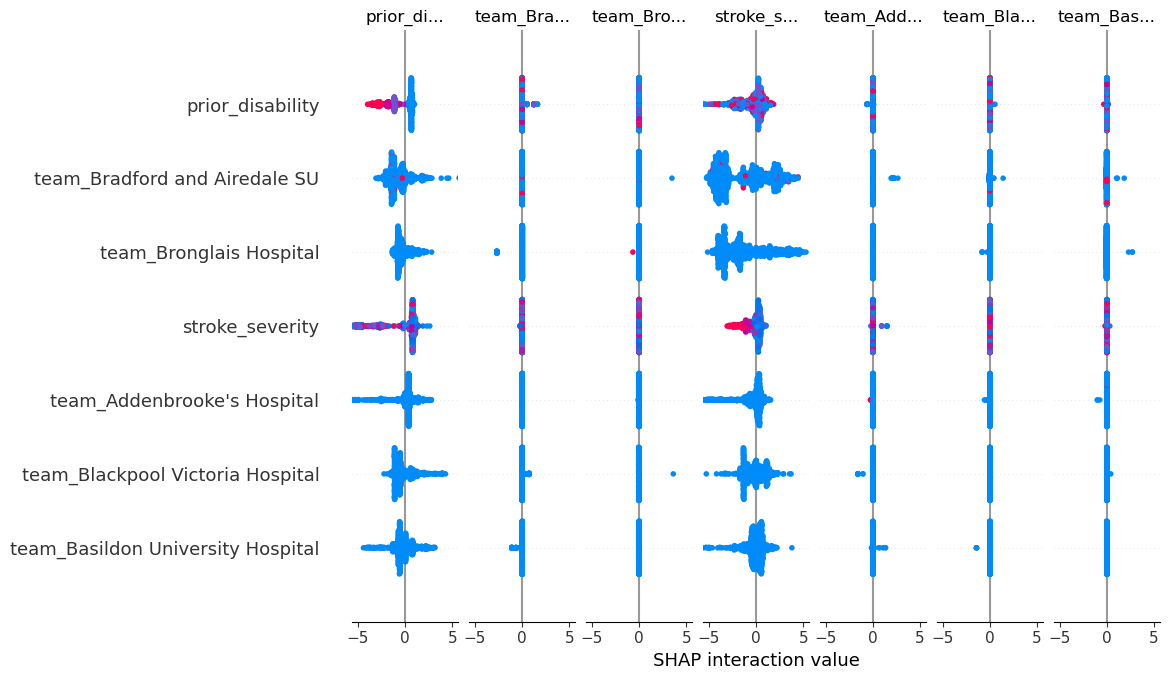

In [62]:
shap.summary_plot(shap_values_xgb_ohe, X_test_data_ohe.values, 
                  plot_type="bar", class_names=class_names, 
                  feature_names=X_test_data_ohe.columns)

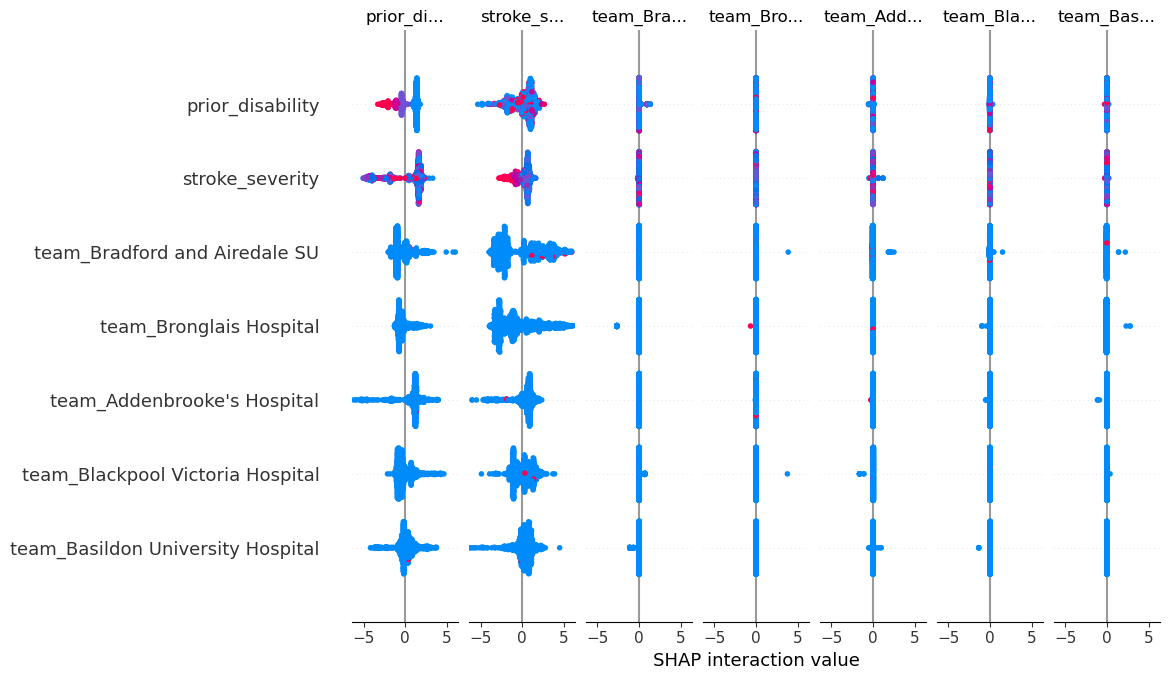

In [63]:
shap.summary_plot(shap_values_xgb_ohe_bg, X_test_data_ohe.values, 
                  plot_type="bar", class_names=class_names, 
                  feature_names=X_test_data_ohe.columns)

IndexError: index 5 is out of bounds for axis 1 with size 3

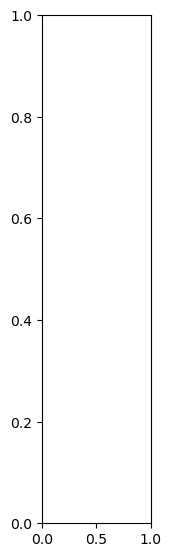

In [64]:
shap.summary_plot(shap_values_lgb_cat, X_test_data_cat.values, 
                  plot_type="bar", class_names=class_names, 
                  feature_names=X_test_data_cat.columns)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

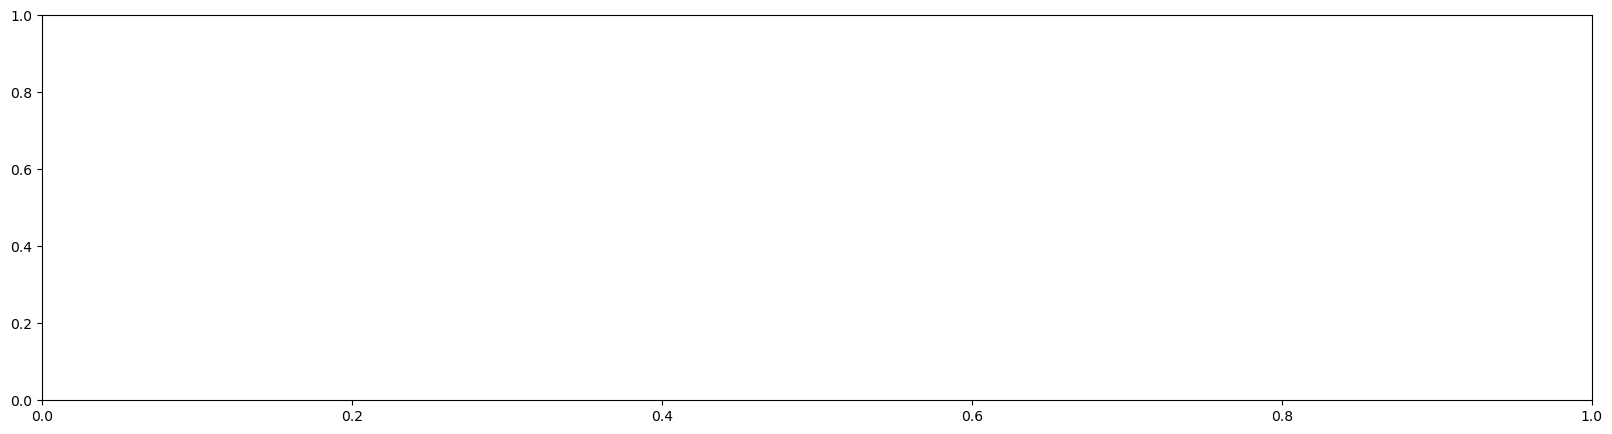

In [71]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax = shap.summary_plot(shap_values_xgb_ohe[cat], X_test_data_ohe.values, 
                       feature_names=X_test_data_ohe.columns, show=False)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

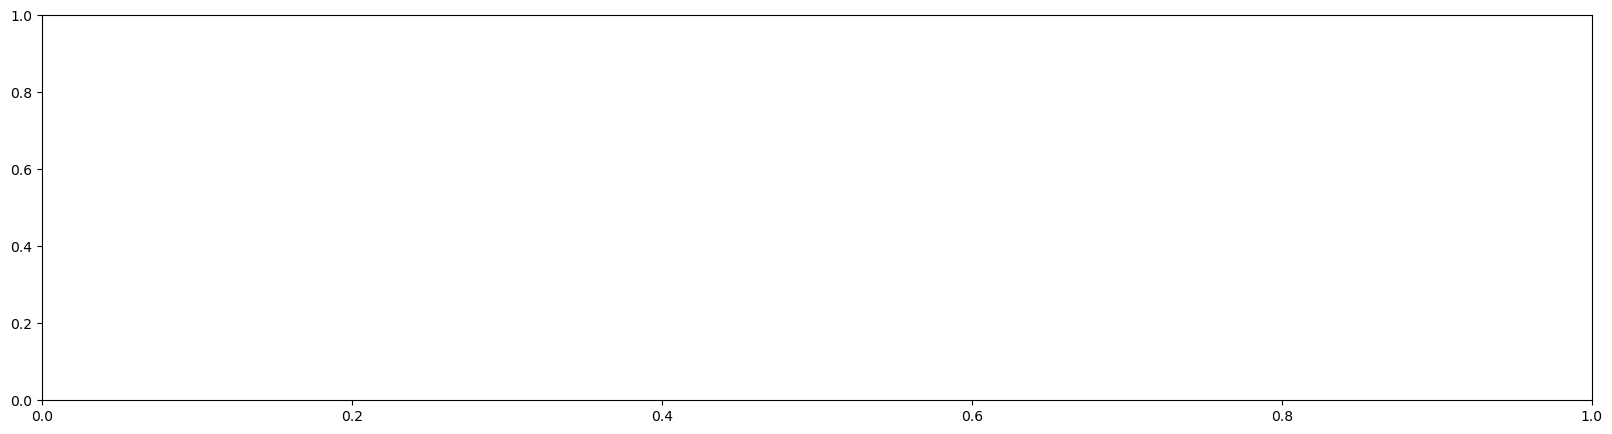

In [74]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax = shap.summary_plot(shap_values_xgb_ohe_bg[cat], X_test_data_cat.values, 
                       feature_names=X_test_data_cat.columns, show=False)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

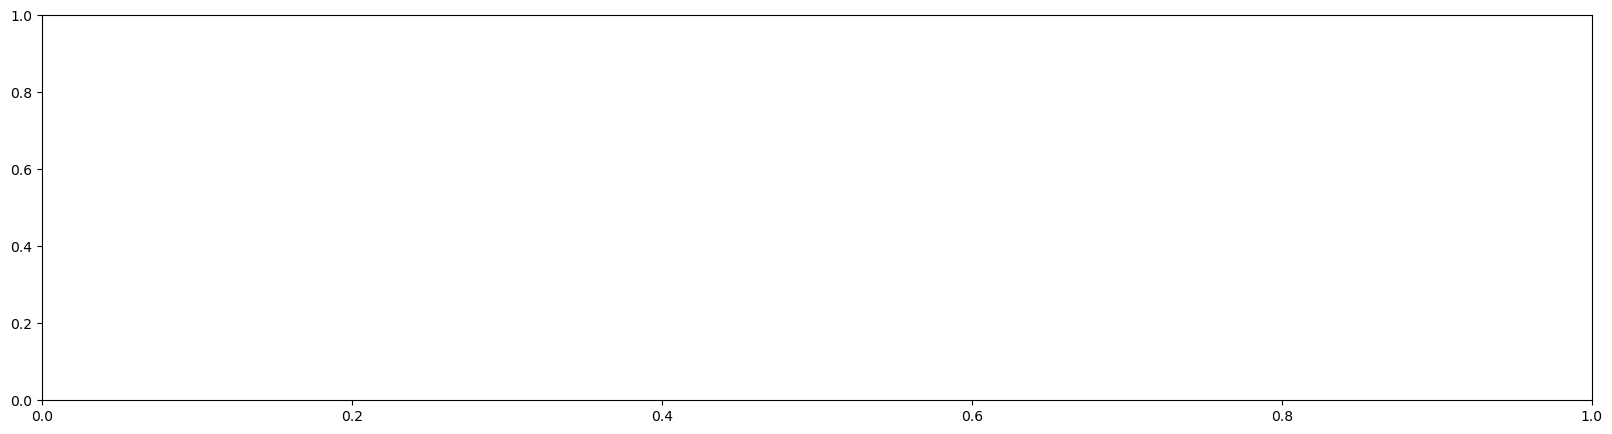

In [70]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax = shap.summary_plot(shap_values_lgb_cat[cat], X_test_data_cat.values, 
                       feature_names=X_test_data_cat.columns, show=False)

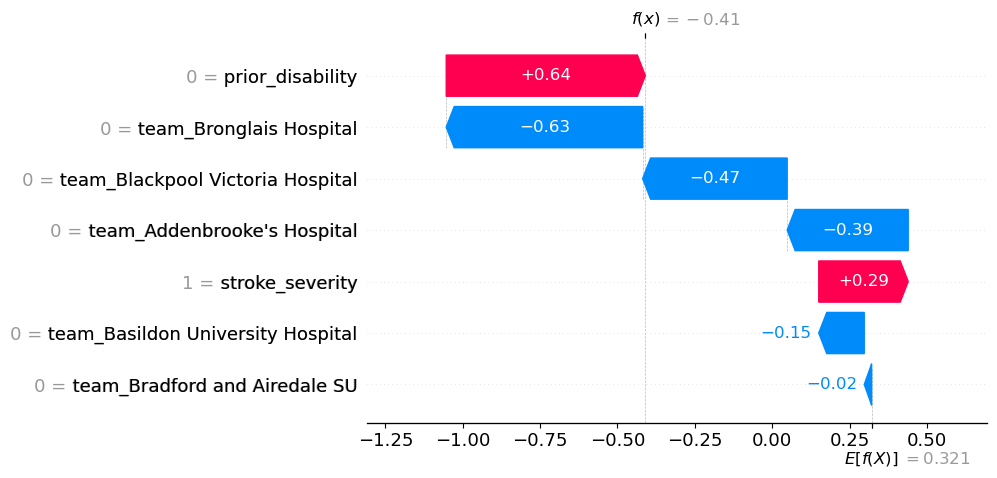

In [77]:
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb_ohe[cat][row], 
                                     base_values=explainer_xgb_ohe.expected_value[cat], 
                                     data=X_test_data_ohe.iloc[row],
                                     feature_names=X_test_data_ohe.columns.tolist()))

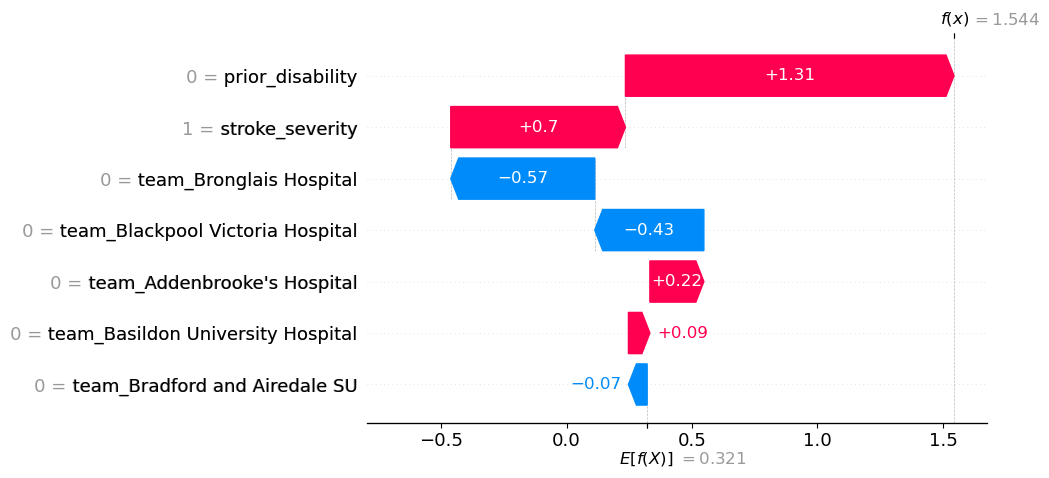

In [78]:
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb_ohe_bg[cat][row], 
                                     base_values=explainer_xgb_ohe.expected_value[cat], 
                                     data=X_test_data_ohe.iloc[row],
                                     feature_names=X_test_data_ohe.columns.tolist()))

Plot waterfall plots for one patient for each of the seven classes

IndexError: index 5 is out of bounds for axis 0 with size 3

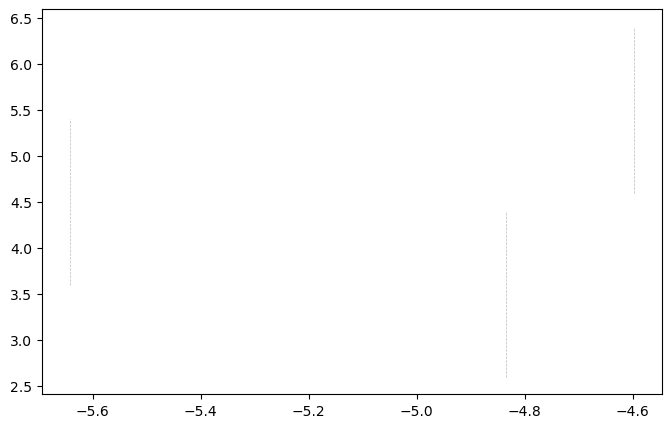

In [79]:
shap.waterfall_plot(shap.Explanation(values=shap_values_lgb_cat[cat][row], 
                                     base_values=explainer_lgb_cat.expected_value[cat], 
                                     data=X_test_data_cat.iloc[row],
                                     feature_names=X_test_data_cat.columns.tolist()))

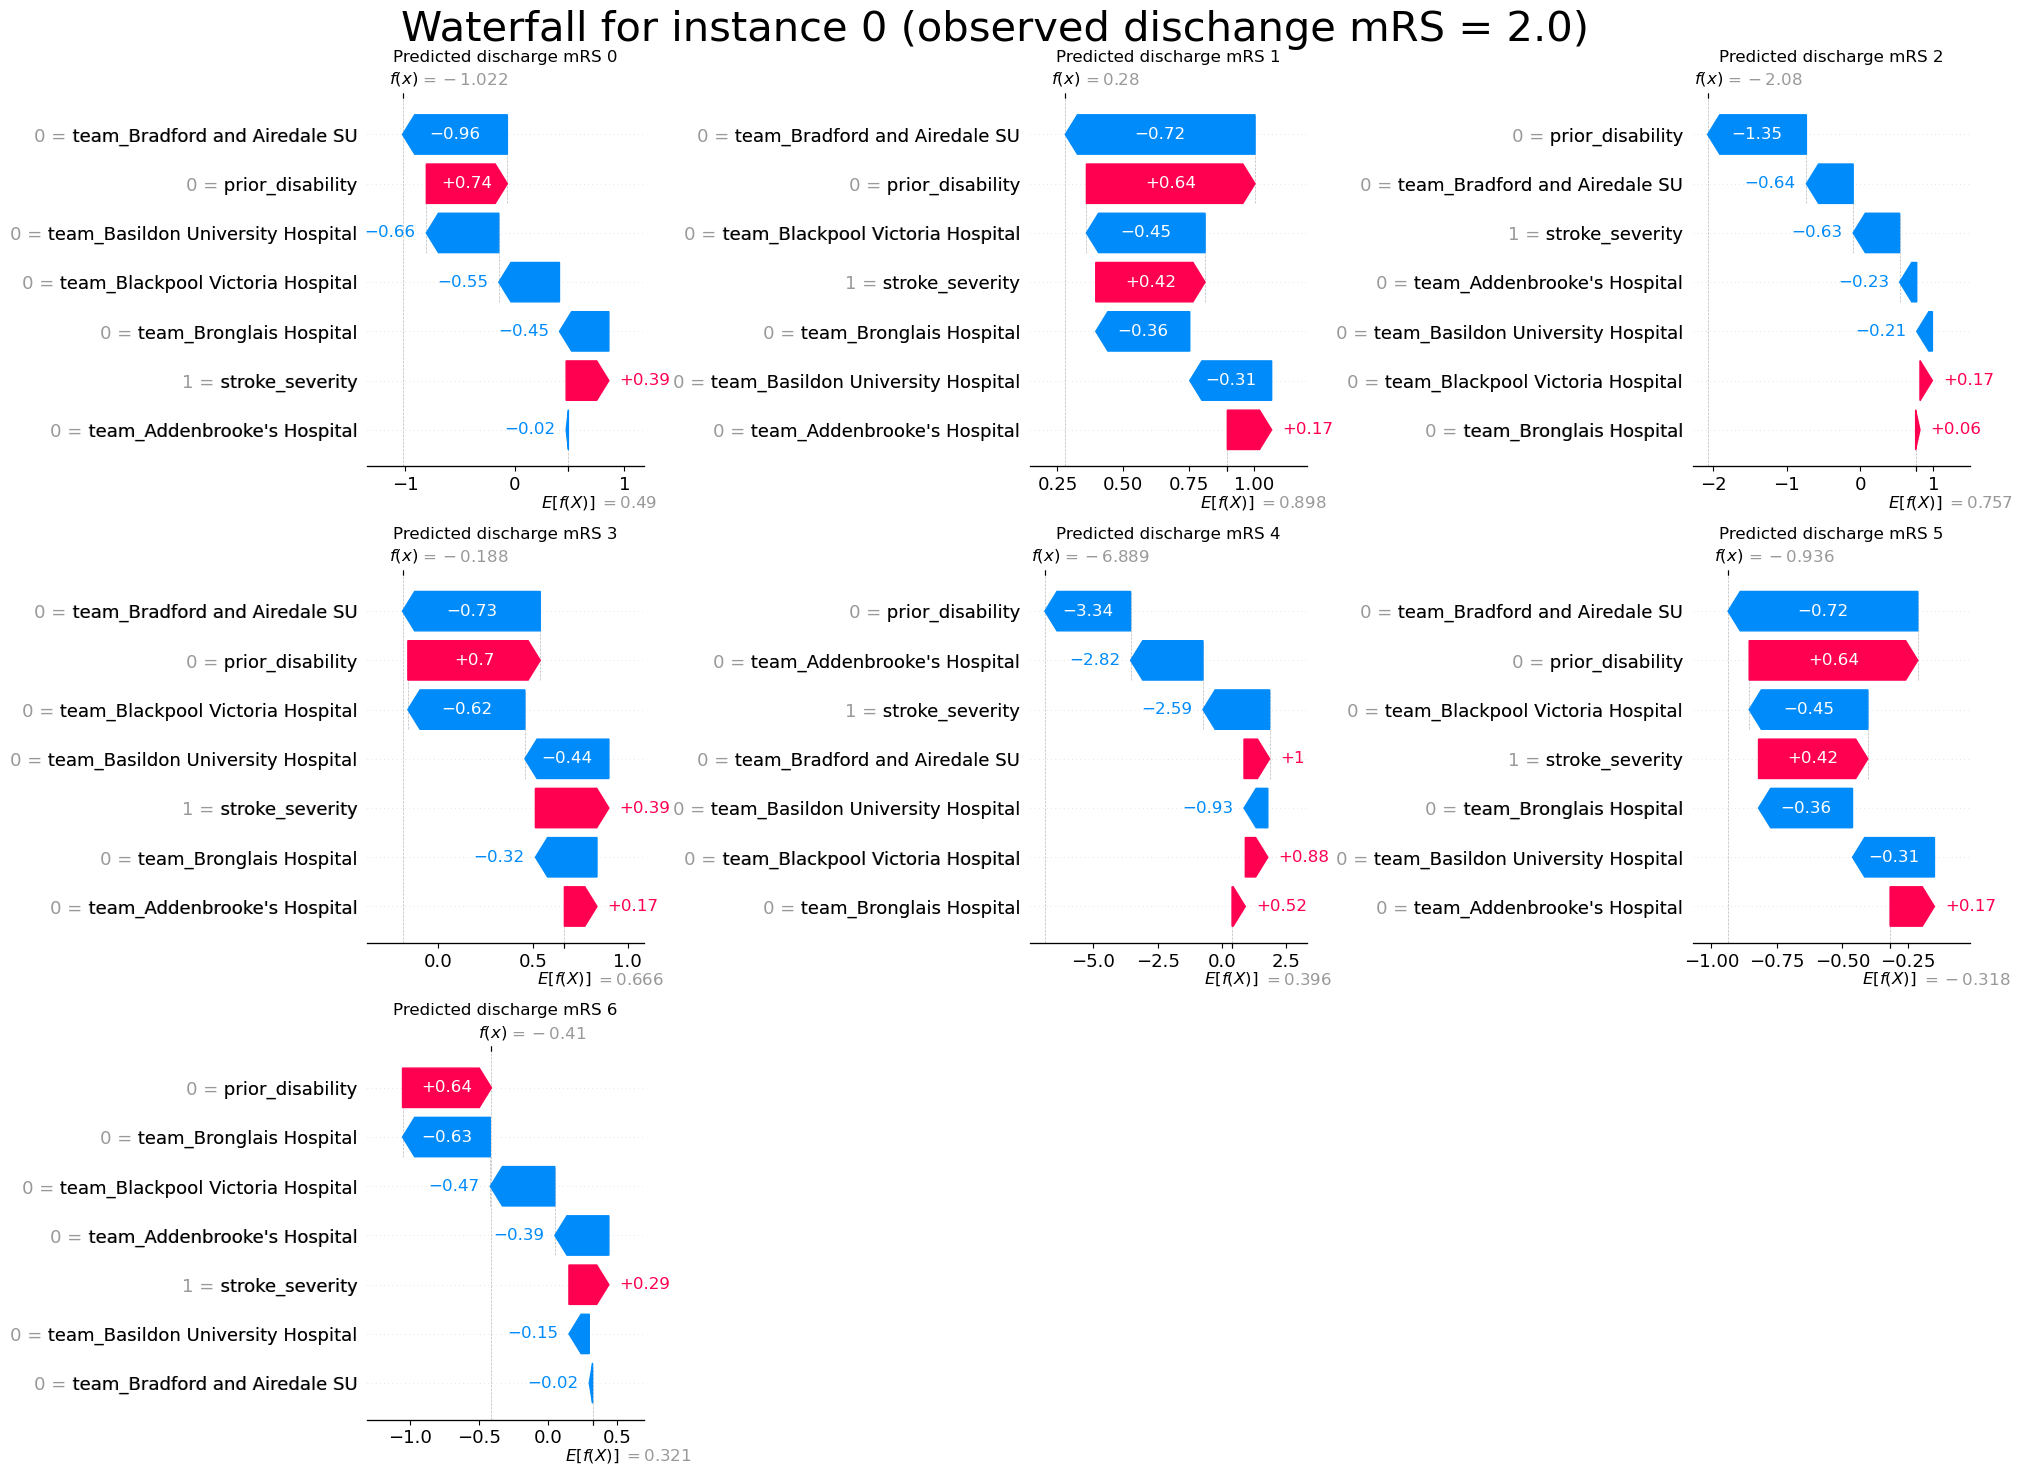

In [80]:
# Create a matrix of subplots per class. Each showing the relationship between
# each combination of features on the SHAP value.
# setup matrix of subplots
fig = plt.figure()

# Set overall title
fig.suptitle(f'Waterfall for instance {row} '
             f'(observed dischange mRS = {y_test_data_ohe.iloc[row]})', 
             fontsize=30)

# Initialise subplot counter
count = 1

for c in range(n_classes):
    ax = fig.add_subplot(3,3,count)
    shap.waterfall_plot(shap.Explanation(values=shap_values_xgb_ohe[c][row], 
                                        base_values=explainer_xgb_ohe.expected_value[c], 
                                        data=X_test_data_ohe.iloc[row],  
                                        feature_names=X_test_data_ohe.columns.tolist()), 
                                        show=False)
    ax. set_title(f"Predicted discharge mRS {c}")
    # Increase subplot counter
    count+=1
    
plt.gcf().set_size_inches(20,15)
plt.tight_layout()

plt.show()

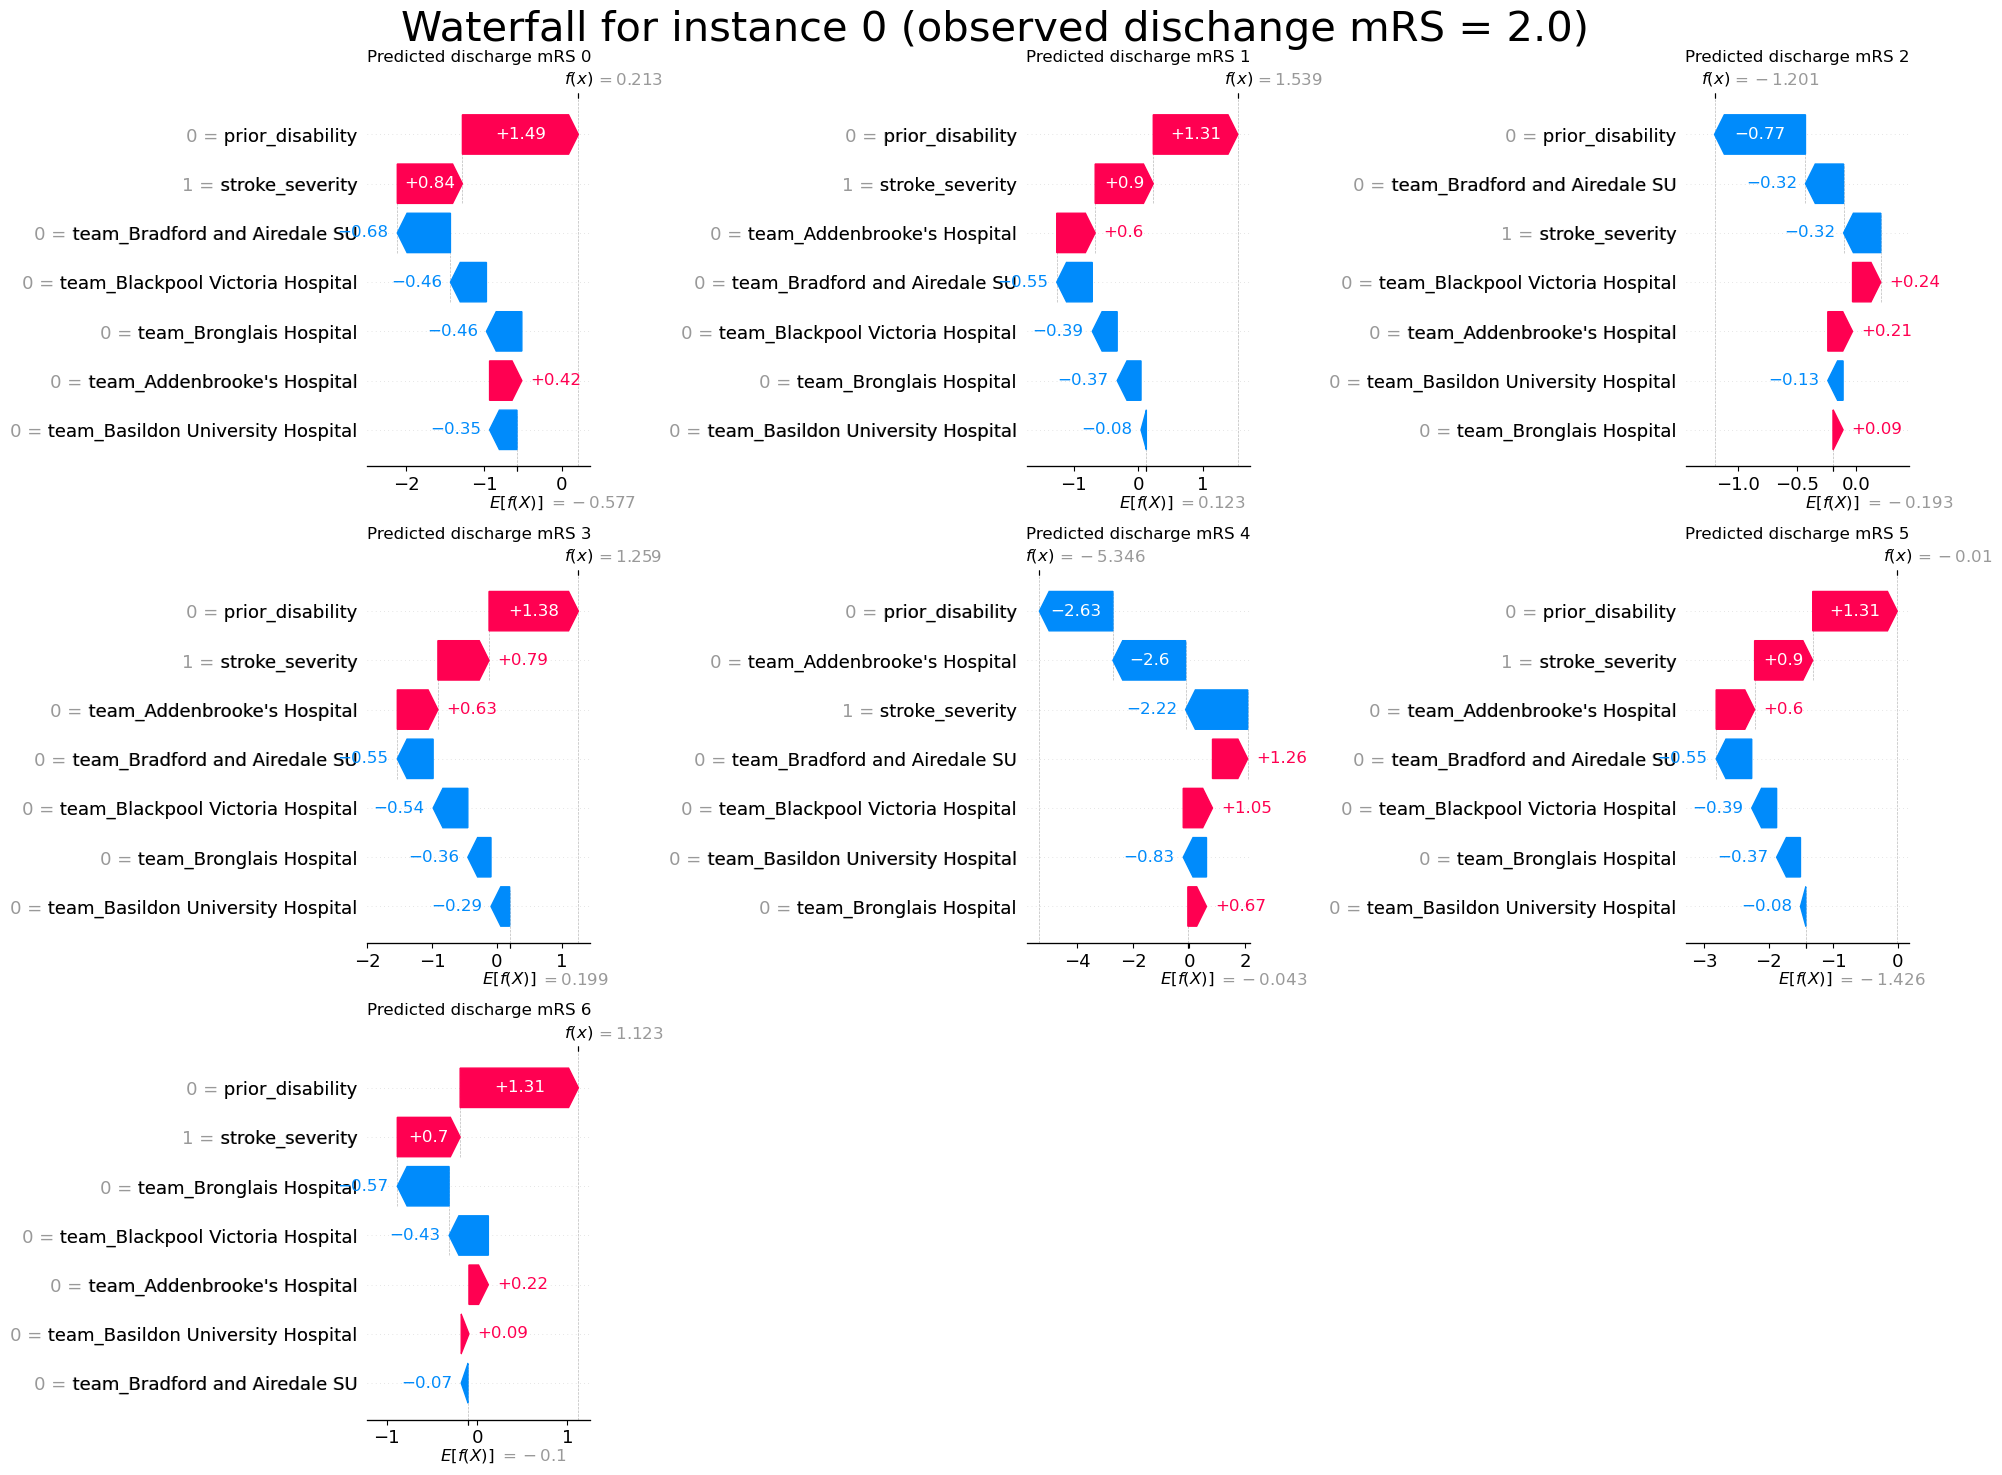

In [81]:
# Create a matrix of subplots per class. Each showing the relationship between
# each combination of features on the SHAP value.
# setup matrix of subplots
fig = plt.figure()

# Set overall title
fig.suptitle(f'Waterfall for instance {row} '
             f'(observed dischange mRS = {y_test_data_ohe.iloc[row]})', 
             fontsize=30)

# Initialise subplot counter
count = 1

for c in range(n_classes):
    ax = fig.add_subplot(3,3,count)
    shap.waterfall_plot(shap.Explanation(values=shap_values_xgb_ohe_bg[c][row], 
                                        base_values=explainer_xgb_ohe_bg.expected_value[c], 
                                        data=X_test_data_ohe.iloc[row],  
                                        feature_names=X_test_data_ohe.columns.tolist()), 
                                        show=False)
    ax. set_title(f"Predicted discharge mRS {c}")
    # Increase subplot counter
    count+=1
    
plt.gcf().set_size_inches(20,15)
plt.tight_layout()

plt.show()

Making the 3D numpy array (shap_values) match the format required by shap.summary_plot - a list of 7 arrays (shap_values_list).

Only include the number of features want for the plot.

In [ ]:
st_display = 0
end_display = 5

shap_values_list = []
for i in range(n_classes):
    shap_values_list.append(shap_values[:,st_display:end_display,i])

In [ ]:
fig, ax = plt.subplots(1,1)
#fig.legend(loc=4)
ax = shap.summary_plot(shap_values_list, X_data.iloc[:,st_display:end_display].values, 
                       plot_type="bar", 
                       class_names=model.classes_, 
                       feature_names = X_data.iloc[:,st_display:end_display].columns, 
                       class_inds="original",
                       show=False)
#fig.legend(loc=4)
#ax.legend(loc=4)
plt.tight_layout()

Can look at an individual class. Here each subplot shows the results for a class.

In [ ]:
st_display = 0
end_display = 5

shap_values_list = []
for i in range(n_classes):
    shap_values_list.append(shap_values[:,st_display:end_display,i])

In [ ]:
fig = plt.figure(figsize=(10,50))
for i in range(n_classes):  
    ax = fig.add_subplot(1,n_classes,i+1)
    ax = shap.summary_plot(shap_values_list[i], 
                           X_data.iloc[:,st_display:end_display].values, 
                           feature_names=X_data.iloc[:,st_display:end_display].columns, 
                           show=False, auto_size_plot=False)
    #ax.title(f"Class {model.classes_[i]}")

plt.tight_layout()

## SHAP dependency plot

The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 2001 [3]). A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. The partial dependence plot is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome. An assumption of the PDP is that the first feature are not correlated with the second feature. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible. A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. In this example the property value increases significantly when the average number of rooms per dwelling is higher than 6. Each dot is a single prediction (row) from the dataset. The x-axis is the actual value from the dataset. The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction. The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

## Look at these examples using histograms with dependency plots
https://arxiv.org/pdf/2112.11071.pdf

In [ ]:
X_data.columns

In [ ]:
shap_values_list = []
for i in range(n_classes):
    shap_values_list.append(shap_values[:,:,i])

In [ ]:
# If we pass a numpy array instead of a data frame then we
# need pass the feature names in separately
shap.dependence_plot(ind=features_ohe[0], 
                     interaction_index=features_ohe[1], 
                     shap_values=shap_values_list[0], features=X_data.values, 
                     feature_names=X_data.columns)

## Add histograms to the outside of the dependence plot

https://www.nature.com/articles/s41598-021-99920-7
https://stackoverflow.com/questions/74859375/shap-partial-dependence-plots-scatter-plot-regression-line-histogram
https://arxiv.org/pdf/2112.11071

Need new package: statsmodels. Tried to install it following these info
https://www.statsmodels.org/dev/install.html

python -m pip install statsmodels

import matplotlib.gridspec as gridspec
import statsmodels.api as sm

var_one = "prior_disability"
var_two = "stroke_severity"
plot_class = 0

fig = plt.figure(figsize=(12, 12))

gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:5, :4])
ax_xDist = plt.subplot(gs[0, :4])
ax_yDist = plt.subplot(gs[1:5, 4])
  
# lowess
idx = np.where(X_data.columns==var_one)[0][0]
x = X_data.iloc[:,idx]
y_sv = shap_values_list[plot_class][:,idx]
lowess = sm.nonparametric.lowess(y_sv, x, frac=.3)
ax_main.plot(*list(zip(*lowess)), color="#312D2C", linestyle="dashed", )

# shap
shap.dependence_plot(var_one,
                     shap_values_list[plot_class],
                     X_data,
                     interaction_index=var_two,
                     alpha=0.5,
                     dot_size=10,
                     show=False,
                     ax=ax_main)

# histplots
ax_xDist.hist(X_data[var_one], bins=50, edgecolor="black", color="gray")
ax_yDist.hist(X_data[var_two], orientation="horizontal", bins=50, edgecolor="black", color="gray")

plt.show()

In [ ]:
for f in range(4):
    print(f'Feature {features_ohe[f]} has 5%-95% range: {np.nanpercentile(X_data[features_ohe[f]], 5)} to {np.nanpercentile(X_data[features_ohe[f]], 95)}')

In [ ]:
fig = plt.figure(figsize=(12, 12))

gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:5, :4])
ax_xDist = plt.subplot(gs[0, :3])
ax_yDist = plt.subplot(gs[1:5, 4])
  
# If we pass a numpy array instead of a data frame then we
# need pass the feature names in separately
shap.dependence_plot(ind=features_ohe[0], 
                     interaction_index=features_ohe[1], 
                     shap_values=shap_values_list[0], features=X_data.values, 
                     feature_names=X_data.columns, alpha=0.5,
                     show=False, ax=ax_main)

# Want to change colourmap to be full range of stroke severity (at the mo it's set to 5% and 95% percentiles)
# https://github.com/slundberg/shap/issues/695
#                     xmin=X_data[features_ohe[1]].min(), xmax=X_data[features_ohe[1]].max())
#                     xmin="percentile(0)", xmax="percentile(100)")#dot_size=10, 

# histplots
ax_xDist.hist(X_data[features_ohe[0]], bins=50, edgecolor="black", color="gray")
ax_yDist.hist(X_data[features_ohe[1]], orientation="horizontal", bins=50, edgecolor="black", color="gray")

plt.show()

In [ ]:
max_display = 4

# Create a matrix of subplots per class. Each showing the relationship between
# each combination of features on the SHAP value.
for c in range(n_classes):
    # setup matrix of subplots
    fig, axes = plt.subplots(nrows=max_display,
                             ncols=max_display)
    axes = axes.ravel()

    # Set overall title
    fig.suptitle(f'Class {model.classes_[c]}', fontsize=30)

    # Initialise subplot counter
    count = 0

    # Loop through the features to display
    for i in range(max_display):
        # Loop through the features to display
        for j in range(max_display):
            # Create the plot. Pass the axes
            shap.dependence_plot(ind=features_ohe[i], 
                                interaction_index=features_ohe[j], 
                                shap_values=shap_values_list[c], 
                                features=X_data.values, 
                                feature_names=X_data.columns,
                                show=False, ax=axes[count],
                                alpha=0.1)#, dot_size=2)
            # reduce the dot size/transparancy to reveal dense vs sparse areas
            #https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html
            
            # Add line as shap=0
            axes[count].plot([-1, X_data[features_ohe[i]].max()+1],
                             [0,0],c='0.5')
            
            # Increase subplot counter
            count+=1
    
    # Change font size for each subplot
    for ax in axes:
        ax.set_xlabel(ax.get_xlabel(), fontsize=15)
        ax.set_ylabel(ax.get_ylabel(), fontsize=15)
        ax.tick_params(axis='both',which='major',labelsize=15)

    # Visual propoerties of figure
    dimension = 5 * 5
    fig.set_figheight(dimension)
    fig.set_figwidth(dimension)
    fig.tight_layout(pad=2)
    plt.show()

## SHAP Force plot

Force plot gives us the explainability of a single model prediction. In this plot we can see how features contributed to the model’s prediction for a specific observation. It is very convenient to use for error analysis or for a deep understanding of a particular case.

In [ ]:
row = 90
plot_class = 0

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(explainer.expected_value[plot_class], shap_values_list[plot_class][row], 
                X_data.values[row], feature_names = X_data.columns)

## SHAP waterfall plot

Waterfall is another local analysis plot of a single instance prediction, for a single outcome.

In [ ]:
shap.waterfall_plot(shap.Explanation(values=shap_values_list[plot_class][row], 
                                        base_values=explainer.expected_value[plot_class], data=X_data.iloc[row],  
                                        feature_names=X_data.columns.tolist()))

Let's view the waterfall plots for all of the outcome classes for a single instance.


Create a function to create a set of subplots

In [ ]:
def create_waterfall_multiclass_grid(row, y_data_row, n_classes, shap_values_list_row,
                                     base_values, data, feature_names):

    # Create a matrix of subplots per class. Each showing the relationship between
    # each combination of features on the SHAP value.
    # setup matrix of subplots
    fig = plt.figure()

    # Set overall title
    fig.suptitle(f'Waterfall for instance {row} '
                f'(observed dischange mRS = {y_data_row})', 
                fontsize=30)

    # Initialise subplot counter
    count = 1

    for c in range(n_classes):
        ax = fig.add_subplot(4,2,count)
        shap.waterfall_plot(shap.Explanation(values=shap_values_list_row[c], 
                                            base_values=base_values[c], 
                                            data=data,  
                                            feature_names=feature_names), 
                                            show=False)
        ax. set_title(f"Predicted discharge mRS {c}")
        # Increase subplot counter
        count+=1
        
    plt.gcf().set_size_inches(20,15)
    plt.tight_layout()
    # Change font size for each subplot
    #for ax in axes:
    #    ax.set_xlabel(ax.get_xlabel(), fontsize=15)
    #    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    #    ax.tick_params(axis='both',which='major',labelsize=15)

    # Visual propoerties of figure
    #dimension = 5 * 5
    #fig.set_figheight(dimension)
    #fig.set_figwidth(dimension)
    #fig.tight_layout(pad=2)
    plt.show()

    return()

View waterfall plots for all classes for a single instance.

In [ ]:
row = 1

# Through each array in the list and extract just the row want to plot (put that back in the list)
shap_values_list_row=[]
for a in shap_values_list:
    shap_values_list_row.append(a[row,:])

# Call funciton to create subplots
create_waterfall_multiclass_grid(row, y_data.iloc[row], n_classes, 
                                 shap_values_list_row,
                                 explainer.expected_value, X_data.iloc[row], 
                                 X_data.columns.tolist())

In [ ]:
row = 0

# Through each array in the list and extract just the row want to plot (put that back in the list)
shap_values_list_row=[]
for a in shap_values_list:
    shap_values_list_row.append(a[row,:])

# Call function to create subplots
create_waterfall_multiclass_grid(row, y_data.iloc[row], n_classes, 
                                 shap_values_list_row,
                                 explainer.expected_value, X_data.iloc[row], 
                                 X_data.columns.tolist())

# Recreate the violin plots as used for the SHAP paper

Violin plots show the relationship between feature value and SHAP value for all of the features
Output descriptive text to use in the paper to describe the differences a feature value had on the likelihood of receiving thromboylsis.

Resource: https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0 https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [ ]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=7)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)


Create violin plot and descriptive text

In [ ]:
# Features to include in the violin plot grid
features_violin = ['prior_disability','stroke_severity',
                     'onset_to_thrombolysis_time','age']

class_category = 6

In [ ]:
feat = 'onset_to_thrombolysis_time'
class_category = 6

feature_data = shap_values_extended[:, feat, class_category].data
feature_shap = shap_values_extended[:, feat, class_category].values

# If feature has more that 50 unique values, then assume it needs to be 
# binned (otherwise assume they are unique categories)

# bin the data, create a violin per bin

# settings for the plot
rotation = 45
step = 30
n_bins = min(11, np.int((feature_data.max())/step))

# create list of bin values
bin_list = [(i*step) for i in range(n_bins)]
bin_list.append(feature_data.max())
if feat == "onset_to_thrombolysis_time":
    # for -100 for no IVT
    bin_list.insert(0, feature_data.min())

bin_list

In [ ]:
# Number of instances per bin
#counts, edges, plot = plt.hist(feature_data, bins=bin_list)
counts, edges = np.histogram(feature_data, bins=bin_list, density=False)
counts

In [ ]:
plt.hist(feature_data)
plt.show()

In [ ]:
def create_grid_of_violin_plots(features_violin, 
                                class_category,
                                shap_values_extended
                                ):
    # Feature Age needs special consideration. It needs the x ticks to be created,
    # as the other features with over 50 unique values, but age is already grouped 
    # for the model (into 5yr groups) and so is treated as the other type.

    # Create figure
    fig = plt.figure(figsize=(12,14), constrained_layout=True)


    fig.suptitle(f'Model to predict discharge disability mRS = {class_category}', fontsize=20)

    # A subplot showing violin plot for each feature.
    # First prepare the fature data for the violin plot: if feature has more than 
    # 50 unique values then assume it needs to be binned (a violin for each bin)

    # Determine number of rows of subplots by rounding up
    ncols = 2
    nrows = math.ceil(len(features_violin)/ncols)

    # Through each feature
    for n, feat in enumerate(features_violin):    
        
        # Get data and SHAP values
        feature_data = shap_values_extended[:, feat, class_category].data
        feature_shap = shap_values_extended[:, feat, class_category].values

        # If feature has more that 50 unique values, then assume it needs to be 
        # binned (otherwise assume they are unique categories)

        if np.unique(feature_data).shape[0] > 50:
            # bin the data, create a violin per bin
            
            # settings for the plot
            rotation = 45
            step = 30
            n_bins = min(11, np.int((feature_data.max())/step))
            
            # create list of bin values
            bin_list = [(i*step) for i in range(n_bins)]
            bin_list.append(feature_data.max())
            if feat == "onset_to_thrombolysis_time":
                # for -100 for no IVT
                bin_list.insert(0, feature_data.min())

            # Number of instances per bin
            #counts, edges, plot = plt.hist(feature_data, bins=bin_list)
            counts, edges = np.histogram(feature_data, bins=bin_list, density=False)

            # create list of bins (the unique categories)
            category_list = [f'{i*step}-{((i+1)*step-1)}\n[n={int(counts[i+1])}]' for i in range(n_bins-1)]
            category_list.append(f'{(n_bins-1)*step}+\n[n={int(counts[-1])}]')
            if feat == "onset_to_thrombolysis_time":
                # for -100 for no IVT
                category_list.insert(0, f'Not receive IVT\n[n={int(counts[0])}]')

            # bin the feature data
            feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                                right=False)

            # create a list, each entry contains the corresponsing SHAP value for that 
            # category (or bin). A violin will represent each list.    
            shap_per_category = []
            for category in category_list:
                mask = feature_data == category
                shap_per_category.append(feature_shap[mask])

        else:
            # create a violin per unique value
            
            # settings for the plot
            rotation = 90
            
            # create list of unique categories in the feature data
            category_list = np.unique(feature_data)

            # Age needs to keep its decimal value (midpoint between 5 yrs)
            if feat != 'age':
                category_list = [int(i) for i in category_list]

            # create a list, each entry contains the corresponsing SHAP value for that 
            # category (or bin). A violin will represent each list.    
            count = []
            shap_per_category = []
            for category in category_list:
                mask = feature_data == category
                shap_per_category.append(feature_shap[mask])
                count.append(mask.sum())
#                if feat == 'stroke_severity':
#                    print(feature_shap[mask].max())

            if feat == 'age':
                # create text of x ticks
                category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for i in category_list]

                # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
                #   the other ages). To accommodate this, if last age category is "110"
                #   then overwrite the label with the correct band (100-120), and not
                #   107-112 as the above code would create.
                if category_list[-1] == '107-112':
                    category_list[-1] = '100-120'
            if feat == 'stroke_severity':
                # not enough space of chart for 2 lines fo x tick labels
                category_list = [f'{category_list[i]} [n={count[i]}]' for i in range(len(category_list))]
            else:
                category_list = [f'{category_list[i]}\n[n={count[i]}]' for i in range(len(category_list))]

        # create violin plot
        ax = fig.add_subplot(nrows,ncols,n+1)

        ax.violinplot(shap_per_category, showmeans=True, widths=0.9)

        # Add line at Shap = 0
        feature_values = shap_values_extended[:, feat].data
        ax.plot([0, len(feature_values)], [0,0],c='0.5')   

        # customise the axes
        ax = set_ax(ax, category_list, feat, rotation=rotation)
        plt.subplots_adjust(bottom=0.15, wspace=0.05)

        # Adjust stroke severity tickmarks
        if feat == 'Stroke severity':
            ax.set_xticks(np.arange(1, len(category_list)+1, 2))
            ax.set_xticklabels(category_list[0::2])   
            
        # Add title
        ax.set_title(feat)
        
    plt.tight_layout(pad=2)
        
    fig.savefig(f'{paths.notebook}{paths.model_text}_thrombolysis_shap_violin_all_'
                f'features_for_mRS{class_category}.jpg', 
                dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()
    return()

In [ ]:
for class_category in range(n_classes):
    create_grid_of_violin_plots(features_violin, 
                                class_category,
                                shap_values_extended
                                )

### Show some of the violins for class 6 as multiple patient populations.

1) Feature onset to thrombolysis time, divide by stroke severity (using 10 as the split).
2) Feature onset to thrombolysis time, divide by stroke severity (using 5, 10, 25 as the splits)
3) Feature onset to thrombolysis time, divide by stroke severity (using 5 as the split)
4) Feature onset to thrombolysis time, divide by stroke severity (using Wikipedia stroke severity split: https://en.wikipedia.org/wiki/National_Institutes_of_Health_Stroke_Scale)
5) Feature stroke severity, divide by get IVT or not get IVT
6) Feature stroke severity, divide by get IVT early (<2hrs), get IVT late (>2hrs) or not get IVT

In [ ]:
def violin_subpopulations(list_masks, list_titles, feature_data, feature_shap, 
                          rotation, bin_list=bin_list, step=step, n_bins=n_bins): 
                          #,ymin=ymin,ymax=ymax):

    # A subplot showing violin plot for each feature.
    # First prepare the fature data for the violin plot: if feature has more than 
    # 50 unique values then assume it needs to be binned (a violin for each bin)

    # Initialise vlaues so they can be immediately improved. Stores the overall min and max of y axis ranges for all subplots.
    ymin = 999
    ymax = -999

    # Determine number of rows of subplots by rounding up
    ncols = min(len(list_masks),2)
    nrows = int(math.ceil(len(list_masks)/ncols))

    figwidth = 12
    figheight = 7 * nrows

    # Create figure
    fig = plt.figure(figsize=(figwidth,figheight), constrained_layout=True)

    fig.suptitle(f'Model to predict discharge disability mRS = {class_category}', fontsize=20)


    plot_mean_shap_per_category = []
    plot_median_shap_per_category = []
    plot_sem_shap_per_category = []

    for i in range(len(list_titles)):
        feature_data_plot = feature_data[list_masks[i]]
        feature_shap_plot = feature_shap[list_masks[i]]

        if np.unique(feature_data).shape[0] > 50:            
            # Number of instances per bin
            #counts, edges, plot = plt.hist(feature_data, bins=bin_list)
            counts, edges = np.histogram(feature_data_plot, bins=bin_list, density=False)

            # create list of bins (the unique categories)
            category_list = [f'{i*step}-{((i+1)*step-1)}\n[n={int(counts[i+1])}]' for i in range(n_bins-1)]
            category_list.append(f'{(n_bins-1)*step}+\n[n={int(counts[-1])}]')
            if feat == "onset_to_thrombolysis_time":
                # for -100 for no IVT
                category_list.insert(0, f'Not receive IVT\n[n={int(counts[0])}')

            # bin the feature data
            feature_data_plot = pd.cut(feature_data_plot, bin_list, labels=category_list, 
                                right=False)

        else:
            category_list = np.unique(feature_data)

        # create a list, each entry contains the corresponsing SHAP value for that 
        # category (or bin). A violin will represent each list.    
        shap_per_category = []
        mean_shap_per_category = []
        median_shap_per_category = []
        sem_shap_per_category = []
        if np.unique(feature_data).shape[0] < 51:            
            count = []

        for category in category_list:
            mask = feature_data_plot == category
            shap_per_category.append(feature_shap_plot[mask])
            mean = feature_shap_plot[mask].mean()
            mean_shap_per_category.append(mean)
            median = np.median(feature_shap_plot[mask])
            median_shap_per_category.append(median)
            stddev = np.std(feature_shap_plot[mask])
            sem_shap_per_category.append(stddev/math.sqrt(mask.sum()))
            if np.unique(feature_data).shape[0] < 51:            
                count.append(mask.sum())

        if np.unique(feature_data).shape[0] < 51:       
            if feat == 'stroke_severity':
                # not enough space of chart for 2 lines fo x tick labels
                category_list = [f'{category_list[i]} [n={count[i]}]' for i in range(len(category_list))]
            else:
                category_list = [f'{category_list[i]}\n[n={count[i]}]' for i in range(len(category_list))]

        # create violin plot
        ax = fig.add_subplot(nrows,ncols,i+1)

        # https://stackoverflow.com/questions/33822239/matplotlib-violinplot-valueerror-with-empty-lists
        nans = [float('nan'), float('nan')] # requires at least 2 nans

        ax.violinplot([val if val.any() else nans for val in shap_per_category], 
                  showmeans=True, widths=0.9)
    
    #    ax.violinplot(shap_per_category, showmeans=True, widths=0.9)

        # Add line at Shap = 0
        feature_values = shap_values_extended[:, feat].data
        ax.plot([0, len(feature_values)], [0,0],c='0.5')   

        # customise the axes
        ax = set_ax(ax, category_list, feat, rotation=rotation)
        plt.subplots_adjust(bottom=0.15, wspace=0.05)
#        ax.set_ylim(-1, 1.75)
        ymin = min(ax.get_ylim()[0],ymin)
        ymax = max(ax.get_ylim()[1], ymax)
        
        # Add title
        ax.set_title(list_titles[i])
        plot_mean_shap_per_category.append(mean_shap_per_category)
        plot_median_shap_per_category.append(median_shap_per_category)
        plot_sem_shap_per_category.append(sem_shap_per_category)

    plt.tight_layout(pad=2)

    # Use the same y limits for all of the subplots
    # To use the range from the first subplot use: ylim=ax[0,0].get_ylim()
    plt.setp(ax, ylim=(ymin,ymax))

    #fig.savefig(f'{paths.notebook}_{paths.model_text}_thrombolysis_shap_violin_all_'
    #        f'features_for_mRS{class_category}.jpg', 
    #        dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()
    return(plot_mean_shap_per_category, plot_median_shap_per_category, plot_sem_shap_per_category)

In [ ]:
def lineplot_subpopulations(plot_mean_shap_per_category, plot_sem_shap_per_category, list_titles,n_bins=n_bins, step=step):
    # Create figure
    fig = plt.figure(figsize=(10,5), constrained_layout=True)
    ax = fig.add_subplot(1,1,1)

    if np.unique(feature_data).shape[0] < 50:            
        category_list = np.unique(feature_data)

    else:

        category_list = [f'{i*step}-{((i+1)*step-1)}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')
        if feat == "onset_to_thrombolysis_time":
                # for -100 for no IVT
                category_list.insert(0, f'Not receive IVT')


    for i in range(len(plot_mean_shap_per_category)):
        ax.errorbar(range(1,len(plot_mean_shap_per_category[i])+1), 
                plot_mean_shap_per_category[i],
                label=list_titles[i],
                yerr=plot_sem_shap_per_category[i])
    #ax.plot(range(43), plot_mean_shap_per_category[1])

    # Add line at Shap = 0
    ax.plot([0, len(plot_mean_shap_per_category[0])], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    #ax.set_ylim(-1.9, 4.5)

    # Add title
    ax.set_title("Mean SHAP (sem) for feature onset to thrombolysis time, by stroke severity")

    ax.legend(loc=4)

    plt.tight_layout(pad=2)

    #fig.savefig(f'{paths.notebook}_{paths.model_text}_thrombolysis_shap_violin_all_'
    #        f'features_for_mRS{class_category}.jpg', 
    #        dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()

In [ ]:
class_category = 6
feat = "onset_to_thrombolysis_time"

# Get data and SHAP values
feature_data = shap_values_extended[:, feat, class_category].data
feature_shap = shap_values_extended[:, feat, class_category].values

# settings for the plot
rotation = 45
step = 30
n_bins = min(11, np.int((feature_data.max())/step))

# create list of bin values
bin_list = [(i*step) for i in range(n_bins)]
bin_list.append(feature_data.max())
# for -100 for no IVT
bin_list.insert(0, feature_data.min())

# Divide based on stroke severity.
stroke_severity_data = shap_values_extended[:, "stroke_severity", class_category].data
list_masks = []
mask = stroke_severity_data < 11
list_masks.append(mask)
mask = stroke_severity_data > 10
list_masks.append(mask)

# check each instance is represented exactly once
sum = 0
for i in list_masks:
    sum = sum + i.sum()
print(f"{sum} patients out of {feature_data.shape[0]} total are represented across the graphs")

list_titles = ["Mild strokes (NIHSS 0-10)", "Severe strokes (NIHSS 11+)"]

# Show these populations in violin subplots
(plot_mean_shap_per_category, 
 plot_median_shap_per_category, 
 plot_sem_shap_per_category) = violin_subpopulations(list_masks, list_titles, 
                                                     feature_data, feature_shap,
                                                      rotation, bin_list=bin_list, step=step, n_bins=n_bins)


lineplot_subpopulations(plot_mean_shap_per_category, plot_sem_shap_per_category, list_titles,n_bins=n_bins, step=step)

In [ ]:
class_category = 6
feat = "onset_to_thrombolysis_time"

# Get data and SHAP values
feature_data = shap_values_extended[:, feat, class_category].data
feature_shap = shap_values_extended[:, feat, class_category].values

# settings for the plot
step = 30
n_bins = min(11, np.int((feature_data.max())/step))

# create list of bin values
bin_list = [(i*step) for i in range(n_bins)]
bin_list.append(feature_data.max())
# for -100 for no IVT
bin_list.insert(0, feature_data.min())

# Divide based on stroke severity.
stroke_severity_data = shap_values_extended[:, "stroke_severity", class_category].data
list_masks = []
mask = stroke_severity_data < 6
list_masks.append(mask)
mask = (stroke_severity_data > 5) & (stroke_severity_data < 11)
list_masks.append(mask)
mask = (stroke_severity_data > 10) & (stroke_severity_data < 26)
list_masks.append(mask)
mask = stroke_severity_data > 25
list_masks.append(mask)

# check each instance is represented exactly once
sum = 0
for i in list_masks:
    sum = sum + i.sum()
print(f"{sum} patients out of {feature_data.shape[0]} total are represented across the graphs")

list_titles = ["Mild strokes (NIHSS 0-5)", "Low mid strokes (NIHSS 6-10)", "High mid strokes (NIHSS 11-25)", "Severe strokes (NIHSS 26+)"]

# Show these populations in violin subplots
(plot_mean_shap_per_category, 
 plot_median_shap_per_category, 
 plot_sem_shap_per_category) = violin_subpopulations(list_masks, list_titles, 
                                                     feature_data, feature_shap,
                                                      rotation, bin_list=bin_list, step=step, n_bins=n_bins)


lineplot_subpopulations(plot_mean_shap_per_category, plot_sem_shap_per_category, list_titles, n_bins=n_bins, step=step)

Plot the above four plots on one plot: mean and sem (line per NIHSS category)

In [ ]:
class_category = 6
feat = "onset_to_thrombolysis_time"

# Get data and SHAP values
feature_data = shap_values_extended[:, feat, class_category].data
feature_shap = shap_values_extended[:, feat, class_category].values

# settings for the plot
rotation = 45
step = 30
n_bins = min(11, np.int((feature_data.max())/step))

# create list of bin values
bin_list = [(i*step) for i in range(n_bins)]
bin_list.append(feature_data.max())
# for -100 for no IVT
bin_list.insert(0, feature_data.min())

# Divide based on stroke severity.
stroke_severity_data = shap_values_extended[:, "stroke_severity", class_category].data
list_masks = []
mask = stroke_severity_data < 6
list_masks.append(mask)
mask = stroke_severity_data > 5
list_masks.append(mask)

# check each instance is represented exactly once
sum = 0
for i in list_masks:
    sum = sum + i.sum()
print(f"{sum} patients out of {feature_data.shape[0]} total are represented across the graphs")

list_titles = ["Mild strokes (NIHSS 0-5)", "Severe strokes (NIHSS 6+)"]

# Show these populations in violin subplots
(plot_mean_shap_per_category, 
 plot_median_shap_per_category, 
 plot_sem_shap_per_category) = violin_subpopulations(list_masks, list_titles, 
                                                     feature_data, feature_shap,
                                                      rotation, bin_list=bin_list, step=step, n_bins=n_bins)


lineplot_subpopulations(plot_mean_shap_per_category, plot_sem_shap_per_category, list_titles,n_bins=n_bins, step=step)

Use Wikipedia stroke severity split: https://en.wikipedia.org/wiki/National_Institutes_of_Health_Stroke_Scale

Score	Stroke severity
0   	No stroke symptoms
1–4	    Minor stroke
5–15	Moderate stroke
16–20	Moderate to severe stroke
21–42	Severe stroke

In [ ]:
class_category = 6
feat = "onset_to_thrombolysis_time"

# Get data and SHAP values
feature_data = shap_values_extended[:, feat, class_category].data
feature_shap = shap_values_extended[:, feat, class_category].values

# settings for the plot
rotation = 45
step = 30
n_bins = min(11, np.int((feature_data.max())/step))

# create list of bin values
bin_list = [(i*step) for i in range(n_bins)]
bin_list.append(feature_data.max())
# for -100 for no IVT
bin_list.insert(0, feature_data.min())

# Divide based on stroke severity.
stroke_severity_data = shap_values_extended[:, "stroke_severity", class_category].data
list_masks = []
mask = stroke_severity_data == 0
list_masks.append(mask)
mask = (stroke_severity_data > 0) & (stroke_severity_data < 5)
list_masks.append(mask)
mask = (stroke_severity_data > 4) & (stroke_severity_data < 16)
list_masks.append(mask)
mask = (stroke_severity_data > 15) & (stroke_severity_data < 21)
list_masks.append(mask)
mask = stroke_severity_data > 20
list_masks.append(mask)
list_titles = ["No stroke symptoms (NIHSS 0)", "Minor stroke (NIHSS 1-4)",
               "Moderate stroke (NIHSS 5-15)",
               "Moderate to severe stroke (NIHSS 16-20)", 
               "Severe stroke (NIHSS 21+)"]

# check each instance is represented exactly once
sum = 0
for i in list_masks:
    sum = sum + i.sum()
print(f"{sum} patients out of {feature_data.shape[0]} total are represented across the graphs")

# Show these populations in violin subplots
(plot_mean_shap_per_category, 
 plot_median_shap_per_category, 
 plot_sem_shap_per_category) = violin_subpopulations(list_masks, list_titles, 
                                                     feature_data, feature_shap,
                                                     rotation, bin_list=bin_list, 
                                                     step=step, n_bins=n_bins)

lineplot_subpopulations(plot_mean_shap_per_category, plot_sem_shap_per_category, 
                        list_titles, n_bins=n_bins, step=step)

## Replot the dependency plot of stroke severity for class mRS=6 (death) as a violin plot, and have a violin per stroke severity category, with a graph for those that get IVT, and those that do not get IVT.

(Relationship between Stroke Severity and death, with and without IVT)

Each violin is a severity. Shap value for stroke severity (which is it's contribution for death when take the class 6 output).

Split data by IVT and not IVT. 

Also plot as two lines - the mean & standard error of the mean.

In [ ]:
class_category = 6
feat = "stroke_severity"

# Get data and SHAP values
feature_data = shap_values_extended[:, feat, class_category].data
feature_shap = shap_values_extended[:, feat, class_category].values

# settings for the plot
rotation = 90

# Divide based on receive IVT.
thrombolysis_data = shap_values_extended[:, "onset_to_thrombolysis_time", class_category].data
# Get IVT
list_masks = []
mask = thrombolysis_data > -100
list_masks.append(mask)
# Not get IVT
mask = thrombolysis_data == -100
list_masks.append(mask)

# check each instance is represented exactly once
sum = 0
for i in list_masks:
    sum = sum + i.sum()
print(f"{sum} patients out of {feature_data.shape[0]} total are represented across the graphs")

list_titles = ["Get thrombolysis", "Not get thrombolysis"]


# Show these populations in violin subplots
(plot_mean_shap_per_category, 
 plot_median_shap_per_category, 
 plot_sem_shap_per_category) = violin_subpopulations(list_masks, list_titles, 
                                                     feature_data, feature_shap,
                                                      rotation, bin_list=bin_list, 
                                                      step=step, n_bins=n_bins)


lineplot_subpopulations(plot_mean_shap_per_category, plot_sem_shap_per_category, 
                        list_titles, n_bins=n_bins, step=step)

Divide get thrombolysis into those that get it early, and those that get it late. Using 2 hours as the cut off point.

In [ ]:
class_category = 6
feat = "stroke_severity"


# A subplot showing violin plot for each feature.
# First prepare the feature data for the violin plot: if feature has more than 
# 50 unique values then assume it needs to be binned (a violin for each bin)

# Get data and SHAP values
feature_data = shap_values_extended[:, feat, class_category].data
feature_shap = shap_values_extended[:, feat, class_category].values

# settings for the plot
rotation = 90
step = 30
n_bins = min(11, np.int((feature_data.max())/step))

# create list of bin values
bin_list = [(i*step) for i in range(n_bins)]
bin_list.append(feature_data.max())
# for -100 for no IVT
bin_list.insert(0, feature_data.min())

# Divide based on receive IVT.
thrombolysis_data = shap_values_extended[:, "onset_to_thrombolysis_time", class_category].data
list_masks = []
# Get IVT early (within 2 hours)
mask = (thrombolysis_data > -100) & (thrombolysis_data < 120)
list_masks.append(mask)
# Get IVT later (after 2 hours)
mask = thrombolysis_data > 119
list_masks.append(mask)
# Not get IVT
mask = thrombolysis_data == -100
list_masks.append(mask)

# check each instance is represented exactly once
sum = 0
for i in list_masks:
    sum = sum + i.sum()
print(f"{sum} patients out of {feature_data.shape[0]} total are represented across the graphs")

list_titles = ["Get thrombolysis early (within 2 hours onset)", 
               "Get thrombolysis later (after 2 hours onset)", 
               "Not get thrombolysis"]

# Show these populations in violin subplots
(plot_mean_shap_per_category, 
 plot_median_shap_per_category, 
 plot_sem_shap_per_category) = violin_subpopulations(list_masks, list_titles, 
                                                     feature_data, feature_shap,
                                                     rotation, bin_list=bin_list, step=step, n_bins=n_bins)


lineplot_subpopulations(plot_mean_shap_per_category, plot_sem_shap_per_category, list_titles,n_bins=n_bins, step=step)

#### Compare SHAP values for the hospital features

The hospital feature is a coded value per team.

In [ ]:
def create_histogram_data_and_plot(data_stroke_team,
                                   shap_values,
                                   features,
                                   class_category):

    index = features.index("stroke_team")

    # Set up list for storing patient data and hospital SHAP
    feature_data_with_shap = []

    # Get mean SHAP for stroke team when patient attending that stroke team
    unique_stroketeams_list = list(np.unique(data_stroke_team))
    stroke_team_mean_shap = []
    # Loop through stroke teams
    for stroke_team in unique_stroketeams_list:
        # Identify rows in test data that match each stroke team
        mask = data_stroke_team == stroke_team
        # Extract hospital SHAP for the rows that attend that hosptial, for the class
        stroke_team_shap = shap_values[mask,index,class_category]#shap_values[mask]
        # Get mean
        mean_shap = np.mean(stroke_team_shap)
        # Store mean
        stroke_team_mean_shap.append(mean_shap)
        # Get and store feature data and add SHAP
        feature_data = data[mask]
        feature_data['Hospital_SHAP'] = stroke_team_shap
        feature_data_with_shap.append(feature_data)

    # Concatenate and save feature_data_with_shap
    feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)
    feature_data_with_shap.to_csv(
    f'./{paths.notebook}{paths.model_text}_feature_data_with_hospital_shap.csv', 
        index=False)

    # Create and save shap mean value per hospital
    hospital_data = pd.DataFrame()
    hospital_data["stroke_team"] = unique_stroketeams_list
    hospital_data["shap_mean"] = stroke_team_mean_shap
    hospital_data.to_csv(
        f'./{paths.notebook}{paths.model_text}_mean_shap_per_hospital_for_mRS{class_category}.csv', 
        index=False)

    # Plot histogram of the frequency of the mean SHAP value for the instances for each hospital's own patients
    # Use from violin plots
    # facecolor = [0.12156863, 0.46666667, 0.70588235, 0.3]
    # edgecolor= [0.12156863, 0.46666667, 0.70588235, 1.]
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot()

    ax.hist(stroke_team_mean_shap, bins=np.arange(-1.5, 1.5, 0.1), 
            color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
            ec=[0.12156863, 0.46666667, 0.70588235, 1.], 
            linewidth=1.4)
    ax.set_title(f"Outcome for class {class_category}")
    ax.set_xlabel('SHAP values (mean) for hospital attended')
    ax.set_ylabel('Count')
    plt.savefig(f'./{paths.notebook}{paths.model_text}_hosp_shap_hist.jpg', dpi=300, 
                bbox_inches='tight', pad_inches=0.2)
    plt.show()

    return()

In [ ]:
features = X_data.columns.to_list()

In [ ]:
for class_category in range(n_classes):
    create_histogram_data_and_plot(data["stroke_team"],
                                   shap_values,
                                   features,
                                   class_category)

Identify hospital with zero mean SHAP (to use in the synthetic patient data, notebook 230703_xgb_all_data_synthetic_patients.ipynb)

In [ ]:
class_category = 6
# set high, as comparison
min_mean_shap = 999

index = features.index("stroke_team")

# Get mean SHAP for stroke team when patient attending that stroke team
unique_stroketeams_list = list(np.unique(data["stroke_team"]))
# Loop through stroke teams
for stroke_team in unique_stroketeams_list:
    # Identify rows in test data that match each stroke team
    mask = data["stroke_team"] == stroke_team
    # Extract those rows, for the class
    stroke_team_shap = shap_values[mask,index,class_category]#shap_values[mask]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean

    if abs(mean_shap) < min_mean_shap:
        zero_hospital = stroke_team
        min_mean_shap = mean_shap

# Access the hostpial name from the dictionary, using the value (code) to access the key (hostpial name)
zero_hosp_name = [k for k, v in teams_code_dict.items() if v == zero_hospital]
print(zero_hosp_name)
print(min_mean_shap)

Output descriptive text to use in the paper to describe the differences the hospitalfeature value had on the likelihood of receiving thromboylsis. Convert from log odds to odds.

for class_category in range(n_classes):
    range_shap_log_odds = max(stroke_team_mean_shap) - min(stroke_team_mean_shap)
    odds = math.exp(range_shap_log_odds)
    print(f"There was a {round(odds,2)} fold difference in odds of receiving thrombolysis between hospitals")

## Boxplot (individual hospitals)
Create a boxplot to show the range of SHAP values for each individual one-hot encoded hospital feature.

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of mean SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the mean SHAP value for each hosptial (for those instances that attended the hospital)

In [ ]:
# Get code working for one class
c = 1

In [ ]:
# Access hospital names

# Get list of one-hot encoded hospital column titles
hospital_names_ohe = X_data.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

hospital_names

In [ ]:
# Create list of column indices for these hospital column titles (where do the
#   hospital features exist in the datasets?)
hospital_columns_index = [X_data.columns.get_loc(col) for col in hospital_names_ohe]
# Use this index list to access the hosptial shap values (as array)
hosp_shap_values = shap_values_extended[:,:,c].values[:,hospital_columns_index]
# Put in dataframe with hospital as column title
df_hosp_shap_values = pd.DataFrame(hosp_shap_values, columns = hospital_names)
df_hosp_shap_values

Also include four further columns:

the hospital that the instance attended
contribution from all of the one-hot encoded hospital features
contribution from just the hospital attended
contribution from not attending the rest


Also store values in shap_not_attend_these_hospitals_individual so can create a histogram of not attended hosptials SHAP values for the first instance (for the class=1 output). Seen in the waterfall plots that individual hospitals not attended can have a large contribution

In [ ]:
# Include Stroke team that each instance attended
df_hosp_shap_values["Stroke team"] = data_stroke_team

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_values["all_stroke_teams"] = df_hosp_shap_values.sum(axis=1)

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_attended_hospital = []
shap_not_attend_these_hospitals_sum = []
# have a list, an element per instance, with each element containing array of the not attended hospital SHAP values (lst created using append)
shap_not_attend_these_hospitals_individual_hosp_per_instance = []
# have a list, each element containing a not attended hospital SHAP value. The whole dataset as a list of individual values (list created using extend)
shap_not_attend_these_hospitals_individual_hosp_values = []

# For each patient
for index, row in df_hosp_shap_values.iterrows():
    
    # Get stroke team attended
    stroke_team = row["Stroke team"]

    # Get stroke teams not attended
    set_hospital_names_not_attend = set(hospital_names)
    set_hospital_names_not_attend.remove(stroke_team)
    
    # Get SHAP value for the stroke team attended
    shap_attended_hospital.append(row[stroke_team])
#    not_attend = row.loc[row.index != stroke_team]
    not_attend = row.loc[set_hospital_names_not_attend]
    
    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_not_attend_these_hospitals_sum.append(sum_rest)
    shap_not_attend_these_hospitals_individual_hosp_per_instance.append(not_attend.values)
    shap_not_attend_these_hospitals_individual_hosp_values.extend(not_attend.values)

# Store two new columns in dataframe
df_hosp_shap_values["attended_stroke_team"] = shap_attended_hospital
df_hosp_shap_values["not_attended_stroke_teams"] = (
                                            shap_not_attend_these_hospitals_sum)
                   
# View preview
df_hosp_shap_values.head()

Range of not attended hospital SHAP values for hospitals not attended for the first instance

In [ ]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()

ax.hist(shap_not_attend_these_hospitals_individual_hosp_per_instance[0], 
        color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
        ec=[0.12156863, 0.46666667, 0.70588235, 1.], 
        linewidth=1.4)
plt.show()

Range of not attended hospital SHAP values for hospitals not attended for all of the instances

In [ ]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()

ax.hist(shap_not_attend_these_hospitals_individual_hosp_values, 
        color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
        ec=[0.12156863, 0.46666667, 0.70588235, 1.], 
        linewidth=1.4)
plt.show()

Boxplot (all hospitals together)
Analyse the range of SHAP values for the one-hot encoded hospital features. Show as two populations: 1) the attended hospital, 2) the sum of the hospitals not attended

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.boxplot([shap_attended_hospital, shap_not_attend_these_hospitals_sum],
            labels=["Attended hospital", "Not attend these hospitals"],
            whis=99999, notch=True);
title = ("The range of SHAP values for the one-hot encoded hospital features, "
         "\ndepending on whether attend the hospital, or not")

# Add line at Shap = 0
ax.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
ax.set_title(title)
ax.set_xlabel("Instance population")
ax.set_ylabel("SHAP value");

#plt.savefig(f'./output/{notebook}_{model_text}'
#            f'_hosp_shap_attend_vs_notattend_boxplot.jpg', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)
plt.show()

In [ ]:
# Initialise lists
attend_stroketeam_min = []
attend_stroketeam_q1 = []
attend_stroketeam_mean = []
attend_stroketeam_q3 = []
attend_stroketeam_max = []

# For each hospital, store descriptive statistics of SHAP values for those
#   instances that attend the hospital
for h in hospital_names:
    mask = df_hosp_shap_values['Stroke team'] == h
    stroke_team_masked_data = df_hosp_shap_values[h][mask]
    q1, q3 = np.percentile(stroke_team_masked_data, [25,75])
    attend_stroketeam_min.append(stroke_team_masked_data.min())
    attend_stroketeam_q1.append(q1)
    attend_stroketeam_mean.append(stroke_team_masked_data.mean())
    attend_stroketeam_q3.append(q3)
    attend_stroketeam_max.append(stroke_team_masked_data.max())
    
# Create dataframe with 6 columns
df_hosp_shap_value_stats = pd.DataFrame(hospital_names, columns=["hospital"])
df_hosp_shap_value_stats["shap_min"] = attend_stroketeam_min
df_hosp_shap_value_stats["shap_q1"] = attend_stroketeam_q1
df_hosp_shap_value_stats["shap_mean"] = attend_stroketeam_mean
df_hosp_shap_value_stats["shap_q3"] = attend_stroketeam_q3
df_hosp_shap_value_stats["shap_max"] = attend_stroketeam_max

# sort in descending mean SHAP value order
df_hosp_shap_value_stats.sort_values("shap_mean", ascending=False, inplace=True)                
df_hosp_shap_value_stats.head(5)

Add admission figures to xlabel in boxplot

Create dataframe with admissions and thrombolysis rate per stroke team (index)

In [ ]:
# Get Stroke team name, the stroke team admission numbers, and list of SHAP 
#   values for each instance that attended teh stroke team
unique_stroketeams_list = list(set(data_stroke_team))
admissions = [X_data[f'team_{s}'].sum() for s in unique_stroketeams_list]

df_stroketeam_ivt_adms = pd.DataFrame(unique_stroketeams_list, 
                                      columns=["Stroke team"])
df_stroketeam_ivt_adms["Admissions"] = admissions
df_stroketeam_ivt_adms.set_index("Stroke team", inplace=True)
df_stroketeam_ivt_adms.sort_values("Admissions", ascending=True, inplace=True)

# Calculate IVT rate per hosptial, done at beginning of notebook
#hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]

# Join IVT rate with admissions per hosptial
df_stroketeam_ivt_adms = df_stroketeam_ivt_adms.join(hosp_ivt_rate)

df_stroketeam_ivt_adms

Create data for boxplot. Using order of hospitals from the hosp_shap_stats_df dataframe.

In [ ]:

# Go through this order of hospitals
hospital_order = df_hosp_shap_value_stats["hospital"]
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
attend_stroketeam_groups_ordered = []
not_attend_stroketeam_groups_ordered = []

# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_values['Stroke team'] == h
    attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Not attend
    mask = df_hosp_shap_values['Stroke team'] != h
    not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Label
    ivt_rate = int(df_stroketeam_ivt_adms['Thrombolysis'].loc[h] * 100)
    xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[h]}, "
                  f"{ivt_rate}%)")

Plot the boxplot

Resource for using overall y min and max of both datasets on the 4 plots so have the same range: https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists

In [ ]:
# Plot 30 hospitals on each subplot to aid readability
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this "
      "hospital")

# Group the hospitals into 30
st = 0
ed = 30
inc = ed
max_size = n_hospitals

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin1 = min(min(attend_stroketeam_groups_ordered, key=min))
ymin2 = min(min(not_attend_stroketeam_groups_ordered, key=min))
ymax1 = max(max(attend_stroketeam_groups_ordered, key=max))
ymax2 = max(max(not_attend_stroketeam_groups_ordered, key=max))
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin1
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,35))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)

    # The contribution from this hospital when patients don't attend this 
    #    hospital
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    ax.boxplot(not_attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],
               whis=99999, patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))
       
    # The contribution from this hospital when patients do attend this hosptial
    c1 = "black"
    c2 = "black"
    c3 = "white"
    box_plot = ax.boxplot(attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],
               whis=99999, patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))

    # Set the median for attended hospital boxplots to grey (otherwise default 
    # was orange - confusing when not attended hospital colour choice above is orange)
    for median in box_plot['medians']:
        median.set_color('grey')

    plt.ylabel('SHAP values (one-hot encoded hospital feature)',size=12)
    plt.xlabel('Stroke team (admissions, IVT rate)',size=12)
    plt.ylim(ymin, ymax)
    plt.xticks(rotation=90)
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

plt.subplots_adjust(bottom=0.25, wspace=0.05)
        shap_per_category = []

plt.tight_layout(pad=2)

#plt.savefig(f'./output/{notebook}_{model_text}'
#            f'_individual_hosp_shap_attend_vs_notattend_boxplot.jpg', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)
plt.show()

In [ ]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')